In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100
})



from Finite_volume_method_1D import *

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 240

lambdasinnm = [402,673,986,1545]
KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=140,end=240,showplots=False)

In [3]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls)

50.65080403889541 2.6063739330336935
0.019743023215033014
51.586675422657116 3.108352449394211
0.019384850677173028
62.73179082355842 5.3682208039611705
0.015940880801771373
73.44945585376306 18.24864749229679
0.013614804743972338


In [4]:
def prep_data(neg_offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(neg_offset,neg_offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+neg_offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,0.001,1/8,simtime_approx=simtime,D_const=True)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,dthetadN,Q0,sigma):
    datalist = Parallel(n_jobs=4)(delayed(func_to_parallelize)(t,KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,dthetadN=dthetadN,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def parallelize_plot(params):
     SIM = KID_sim(params,0.001,1/8,simtime_approx=simtime,D_const=True)
     return SIM

def plotsim(dthetadN,Q0,sigma):
    datalist = Parallel(n_jobs=4)(delayed(parallelize_plot)(KID_params(eta_pb=consts.eta_pb_max,sigma_IC=sigma,dthetadN=dthetadN,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [6]:
xfit,yfit=prep_data(-1)
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[1e-4,0.5,10],bounds=[1e-9,np.inf])

100%|█████████▉| time (us): 241.4879395205695   
 99%|█████████▉| time (us): 240.39677359521178
 99%|█████████▉| time (us): 240.4860020517365 
 99%|█████████▉| time (us): 240.4014592557808 
100%|█████████▉| time (us): 241.4879395205695   
 99%|█████████▉| time (us): 240.39677359521178
 99%|█████████▉| time (us): 240.4860020517365 
 99%|█████████▉| time (us): 240.4014592557808 
100%|█████████▉| time (us): 241.48787413920203  
 99%|█████████▉| time (us): 240.39671422106704
 99%|█████████▉| time (us): 240.4859467131463 
 99%|█████████▉| time (us): 240.40140885127752
100%|█████████▉| time (us): 241.4879154419689   
 99%|█████████▉| time (us): 240.39675193767056
 99%|█████████▉| time (us): 240.485981993977  
 99%|█████████▉| time (us): 240.40144108708188
 99%|█████████▉| time (us): 240.71586688993185  
 99%|█████████▉| time (us): 240.3447409736547 
 99%|█████████▉| time (us): 240.05080893700557
 99%|█████████▉| time (us): 240.38748029044697
 99%|█████████▉| time (us): 240.71586688993185 
 9

In [11]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['dthetadN','Q0','sigma']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

Parameters:
dthetadN:	0.0001328120	+/-	0.0000082176
Q0:	0.6107796055	+/-	0.0621522608
sigma:	377.9576855592	+/-	0.0000000000

Correlation Coefficients:
dthetadN vs Q0: -0.9380661748
dthetadN vs sigma: 0.9380661715
Q0 vs sigma: -1.0000000000


In [12]:
simdata = plotsim(popt[0],popt[1],popt[2])

100%|█████████▉| time (us): 240.83311987904975 
 99%|█████████▉| time (us): 240.36703988257923
 99%|█████████▉| time (us): 240.04889391580866
 99%|█████████▉| time (us): 240.08718099688517


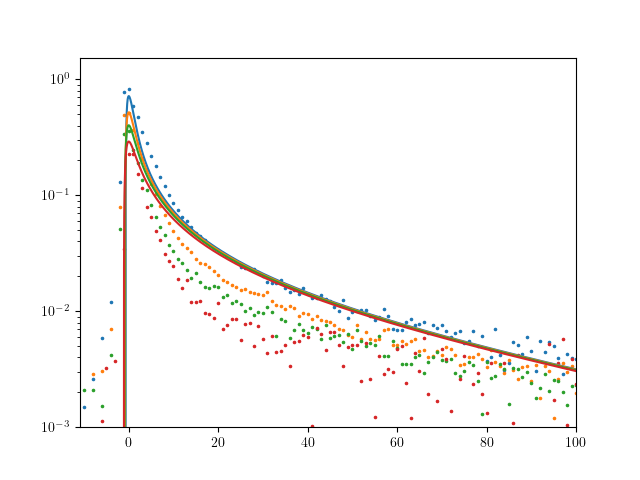

In [14]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.semilogy(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime)
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,100)
plt.ylim(1e-3)
plt.show()